# Data exploration notebook:
- London Air Quality Network (LAQN) data
- Meteorological data from the Heathrow weather station
- Mortality data via Office for National Statistics (ONS)
- Population data via ONS
- Gross Disposable Household Income (GDHI) via ONS

## Imports

In [1]:
import pandas as pd
from os import makedirs, path, listdir, remove
from data_classes import LAQNData, MetData, HealthData, PopData, IncomeData
import requests
from tqdm import tqdm
import numpy as np
import wandb
import matplotlib.pyplot as plt
import zipfile as zpf
import xlrd
from openpyxl import load_workbook

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## LAQN

In [2]:
species = "NO2"
region = "London"

In [3]:
NO2_hourly = LAQNData(species, region)

In [4]:
print(len(NO2_hourly.site_codes))

250


Download the LAQN NO$_2$ data:

In [5]:
start_date = "1996-01-01"
end_date = "2021-01-01"
NO2_hourly.download_and_log(start_date, end_date)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Working on site VS1: 100%|██████████| 239/239 [39:23<00:00,  9.89s/it] 


Load the resampled daily NO$_2$ data:

In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)
daily_NO2_df = NO2.read("laqn-resample")

In [3]:
daily_NO2_df.head()

,BN2,BP0,EI3,BT3,A30,EA1,EN4,EN1,BT5,EN7,...,WAB,WE0,WL2,WL4,WM0,WM5,WM8,WMA,WMZ,WMC
1996-01-01,NaN,NaN,NaN,NaN,NaN,52.300000,NaN,30.200000,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-02,NaN,76.979167,NaN,NaN,NaN,69.366667,NaN,44.378261,NaN,NaN,...,NaN,53.720833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,NaN,73.320833,NaN,NaN,NaN,56.347826,NaN,39.239130,NaN,NaN,...,NaN,56.904167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,NaN,74.929167,NaN,NaN,NaN,59.891667,NaN,47.695652,NaN,NaN,...,NaN,62.004167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,NaN,63.731818,NaN,NaN,NaN,58.891667,NaN,46.678261,NaN,NaN,...,NaN,41.429167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Load the metadata:

In [4]:
meta_url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
sites_request = requests.get(meta_url)
meta_df = pd.DataFrame(sites_request.json()['Sites']['Site'])

In [6]:
meta_df.head()

,@LocalAuthorityCode,@LocalAuthorityName,@SiteCode,@SiteName,@SiteType,@DateClosed,@DateOpened,@Latitude,@Longitude,@LatitudeWGS84,@LongitudeWGS84,@DisplayOffsetX,@DisplayOffsetY,@DataOwner,@DataManager,@SiteLink
0,27,Richmond,TD0,"- National Physical Laboratory, Teddington",Suburban,2018-01-01 00:00:00,1996-08-08 00:00:00,51.4243043441456,-0.345714576446947,6696103.27675,-37808.8858115,0,-200,Richmond,King's College London,http://www.londonair.org.uk/london/asp/publicd...
1,1,Barking and Dagenham,BG3,Barking and Dagenham - North Street,Kerbside,2011-05-25 00:00:00,2007-03-16 00:00:00,51.540444,0.074418,6717454.5833,8284.17386585,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...
2,1,Barking and Dagenham,BG1,Barking and Dagenham - Rush Green,Suburban,,1999-11-02 00:00:00,51.563752,0.177891,6721627.34498,19802.7355367,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...
3,1,Barking and Dagenham,BG2,Barking and Dagenham - Scrattons Farm,Suburban,,1999-10-17 00:00:00,51.529389,0.132857,6715476.18683,14789.5735883,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...
4,2,Barnet,BN2,Barnet - Finchley,Urban Background,2012-04-20 00:00:00,2000-08-09 13:00:00,51.591901,-0.205992,6726669.62886,-22930.9245475,0,0,Barnet,King's College London,http://www.londonair.org.uk/london/asp/publicd...


In [7]:
set(meta_df["@LocalAuthorityName"].tolist())

{'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'City of London',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster'}

## Met data

In [68]:
heathrow = MetData("Heathrow")

Download data:

In [65]:
url = "https://bulk.meteostat.net/hourly/03772.csv.gz"
heathrow.download_and_log(url)

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Load saved data:

In [69]:
variables = ["temperature", "wind_speed"]
hourly_df = heathrow.read(variables, "met-raw")

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact met-raw:latest, 130.92MB. 8 files... Done. 0:0:0


In [70]:
hourly_df = hourly_df.loc[hourly_df.index.year>1970]

### Plot the time series

In [71]:
hourly_df.columns.to_list()

['temperature', 'wind_speed']

In [72]:
hourly_df.temperature.shape

(422556,)

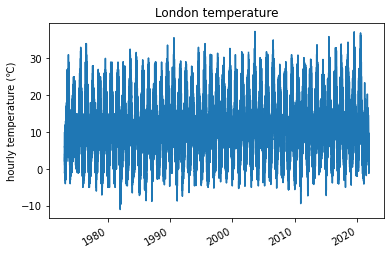

In [75]:
hourly_df["temperature"].plot(title="London temperature").set_ylabel("hourly temperature (℃)")
plt.show()

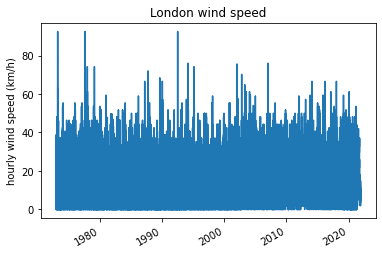

In [76]:
hourly_df["wind_speed"].plot(title="London wind speed").set_ylabel("hourly wind speed (km/h)")
plt.show()

## Mortality (& population)

### Daily mortality
Daily mortality data at regional scale. Here we select for the Greater London region using region code E12000007.

In [27]:
region_code = "E12000007"
start_year = 1981
end_year = 2018

URLs for accessing the data on the ONS website:

In [28]:
urls = {}
urls.update(dict.fromkeys(list(range(1981, 2014+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/005459dailydeathoccurrencesenglandregionsofenglandandwales1970to2014/dailydeathoccurrences19702014.zip"))
urls.update(dict.fromkeys(list(range(2013, 2017+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/009728dailydeathoccurrencesregionsofenglandandwales2013to2016/dailydeathoccurrences20132017.xls"))
urls.update(dict.fromkeys(list(range(2015, 2018+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/11189dailydeathsenglishregionsandwales2015to2018occurrences/dailydeathsfinal.xlsx"))

Download the data:

In [5]:
mortality = HealthData()

In [2]:
#mortality.download_and_log(region_code, start_year, end_year, urls)

Load the data:

In [6]:
daily_df = mortality.read("mortality-raw")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


In [7]:
daily_df.shape

(13879, 1)

In [9]:
daily_df.columns

Index(['deaths'], dtype='object')

Plot the data:

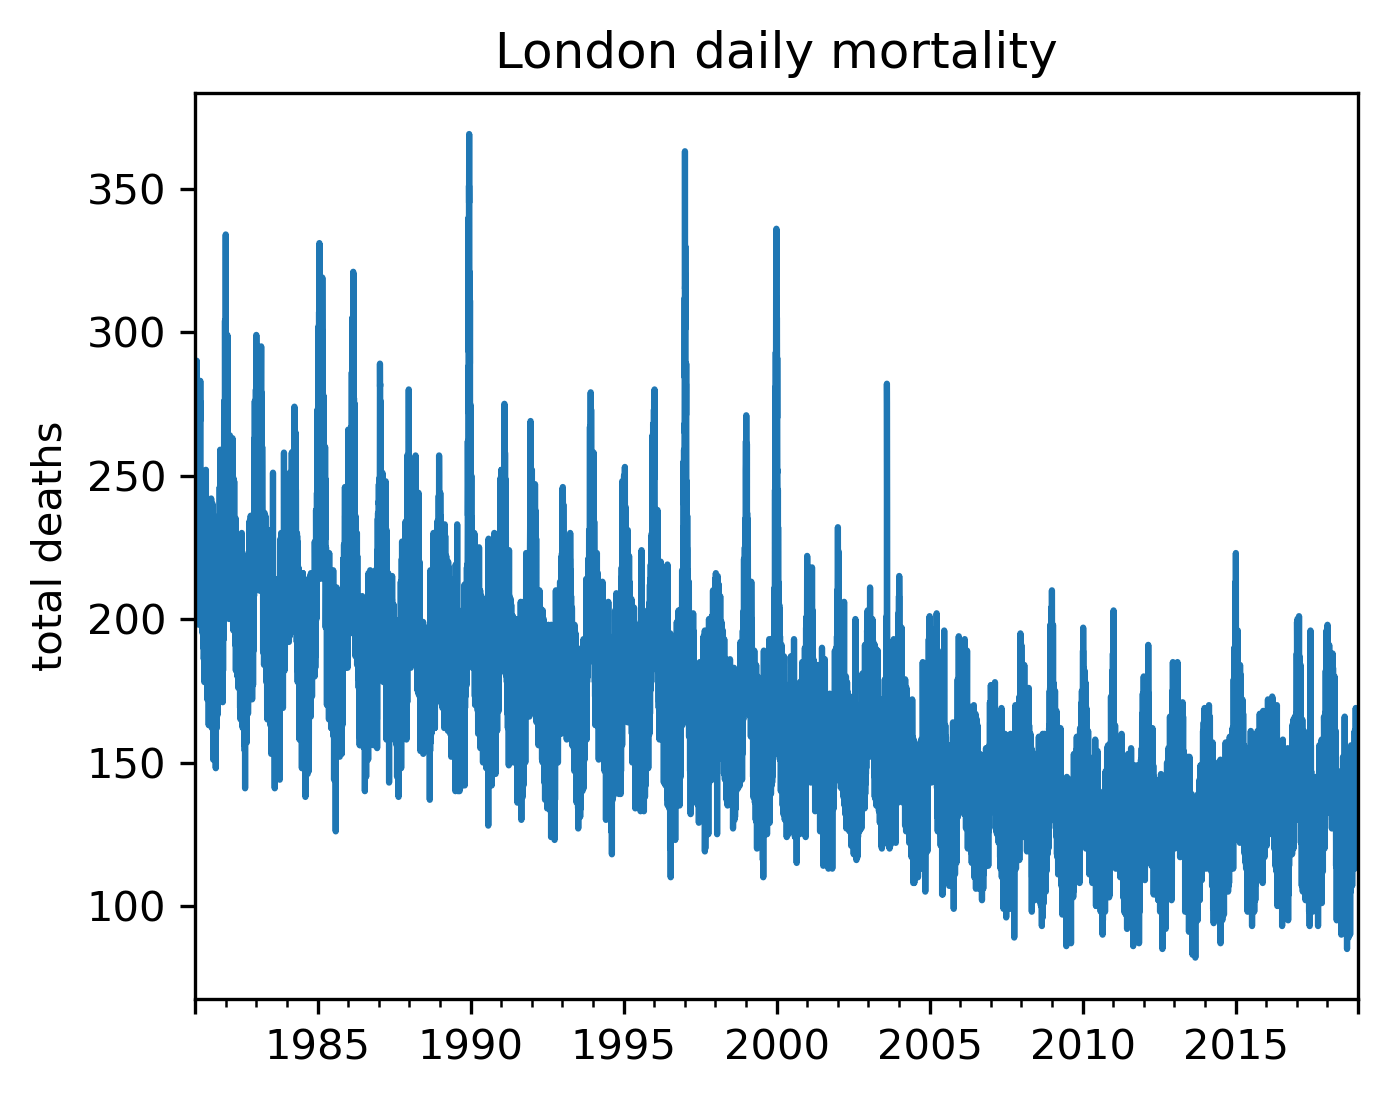

In [21]:
plt.figure(figsize=(5,4), dpi=300)
daily_df['deaths'].plot(legend=False, title="London daily mortality").set_ylabel("total deaths")
plt.show()

### Population data

#### Download & process the population data

In [12]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2001tomid2019detailedtimeseries/regionalpopestimatesforenglandandwales19712019.xlsx"
region_name = "London"
pop_data = PopData()

In [11]:
#pop_data.download_and_log(url, region_name)

#### Load the data

In [13]:
population_df = pop_data.read("population-raw")
population_df.shape

(39, 1)

#### Plot the dataframe

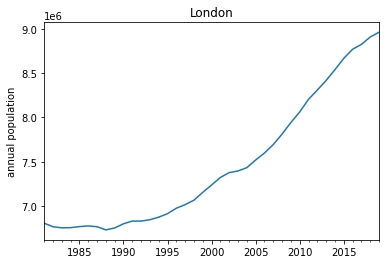

In [62]:
population_df.plot(legend=False, title="London").set_ylabel("annual population")
plt.show()

#### Linear interpolation of annual data

In [4]:
key = "D"
method = "linear"

In [5]:
linear_df = pop_data.resample_time_and_log(key, method)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


In [6]:
linear_df = pop_data.read("population-resample")

In [7]:
linear_df.shape

(13880, 1)

### Calculating deaths as a fraction of population

Daily deaths

In [8]:
df = mortality.scale_per_capita_and_log()

In [14]:
df = mortality.read("mortality-scaled")

In [15]:
df.shape

(13698, 1)

In [22]:
df["deaths_per_100k"] = df["deaths"]*100000

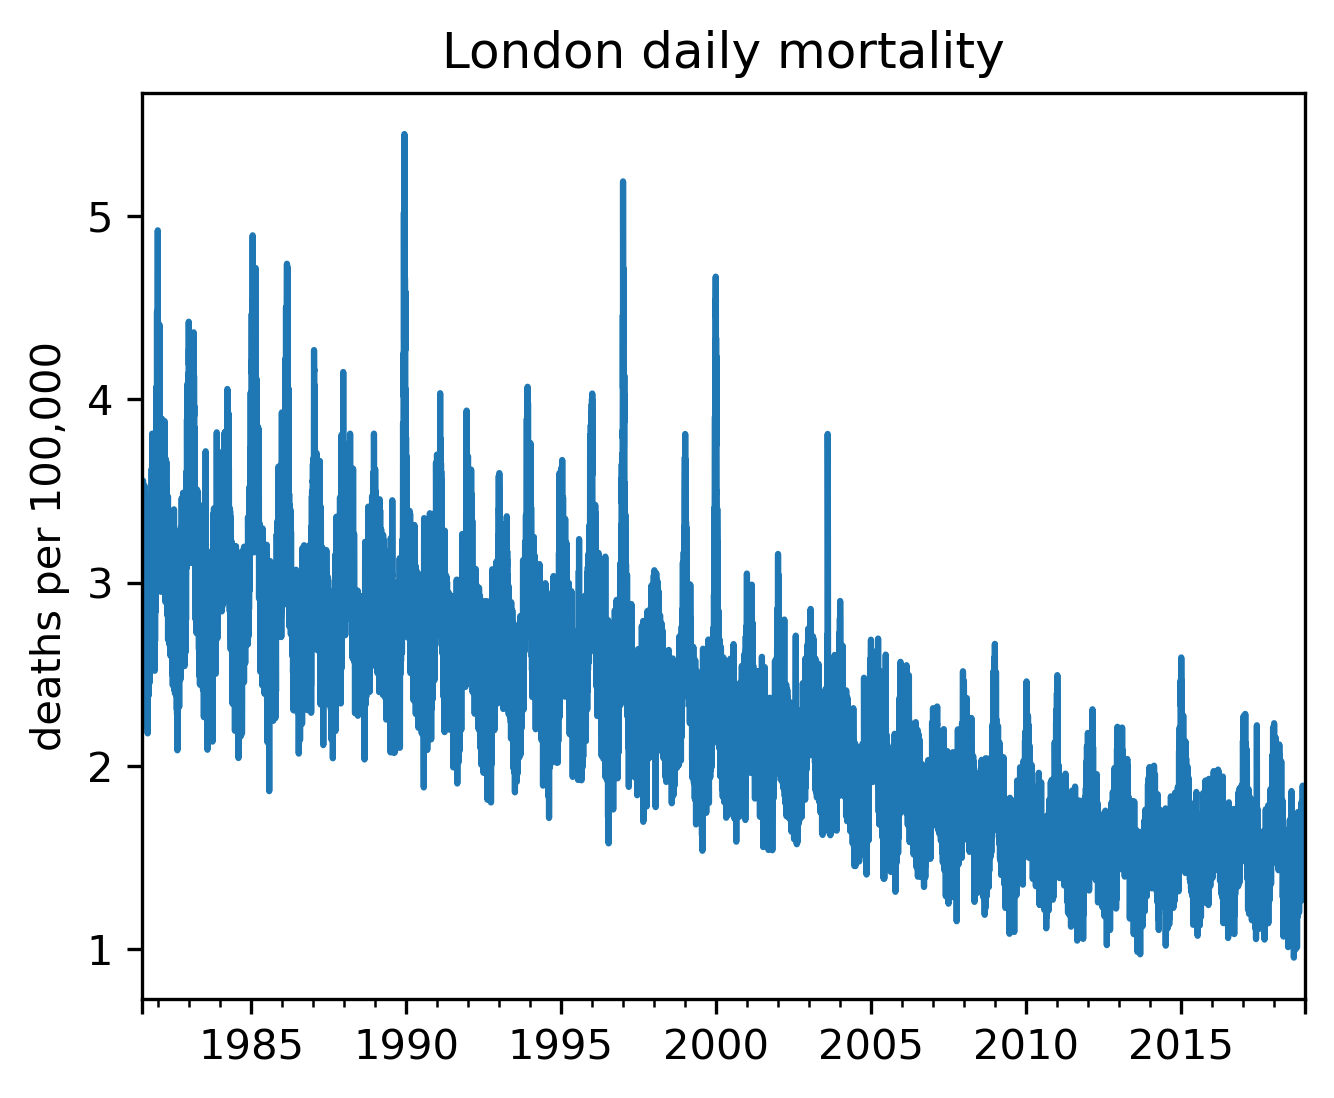

In [23]:
plt.figure(figsize=(5,4), dpi=300)
df["deaths_per_100k"].plot(legend=False, title="London daily mortality").set_ylabel("deaths per 100,000")
plt.show()

## Income data

In [2]:
income = IncomeData()

Download:

In [3]:
url = "https://www.ons.gov.uk/file?uri=/economy/regionalaccounts/grossdisposablehouseholdincome/datasets/regionalgrossdisposablehouseholdincomebylocalauthoritiesbynuts1region/ukilondon/regionalgrossdisposablehouseholdincomelocalauthorityukilondon.xls"
income.download_and_log(url, "London")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Read:

In [162]:
df = income.read("income-raw")

In [175]:
df.shape

(22, 33)

#### Linear interpolation of annual data

In [ ]:
key = "D"
method = "linear"
linear_df = income.resample_time_and_log(key, method)

In [4]:
linear_df = income.read("income-resample")

In [5]:
linear_df.shape

(7671, 33)

In [6]:
rich_df = linear_df.loc[linear_df.index==linear_df.index.max()].transpose().nlargest(3, linear_df.index.max())

In [3]:
LAD_codes_df = income.read("income-metadata")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


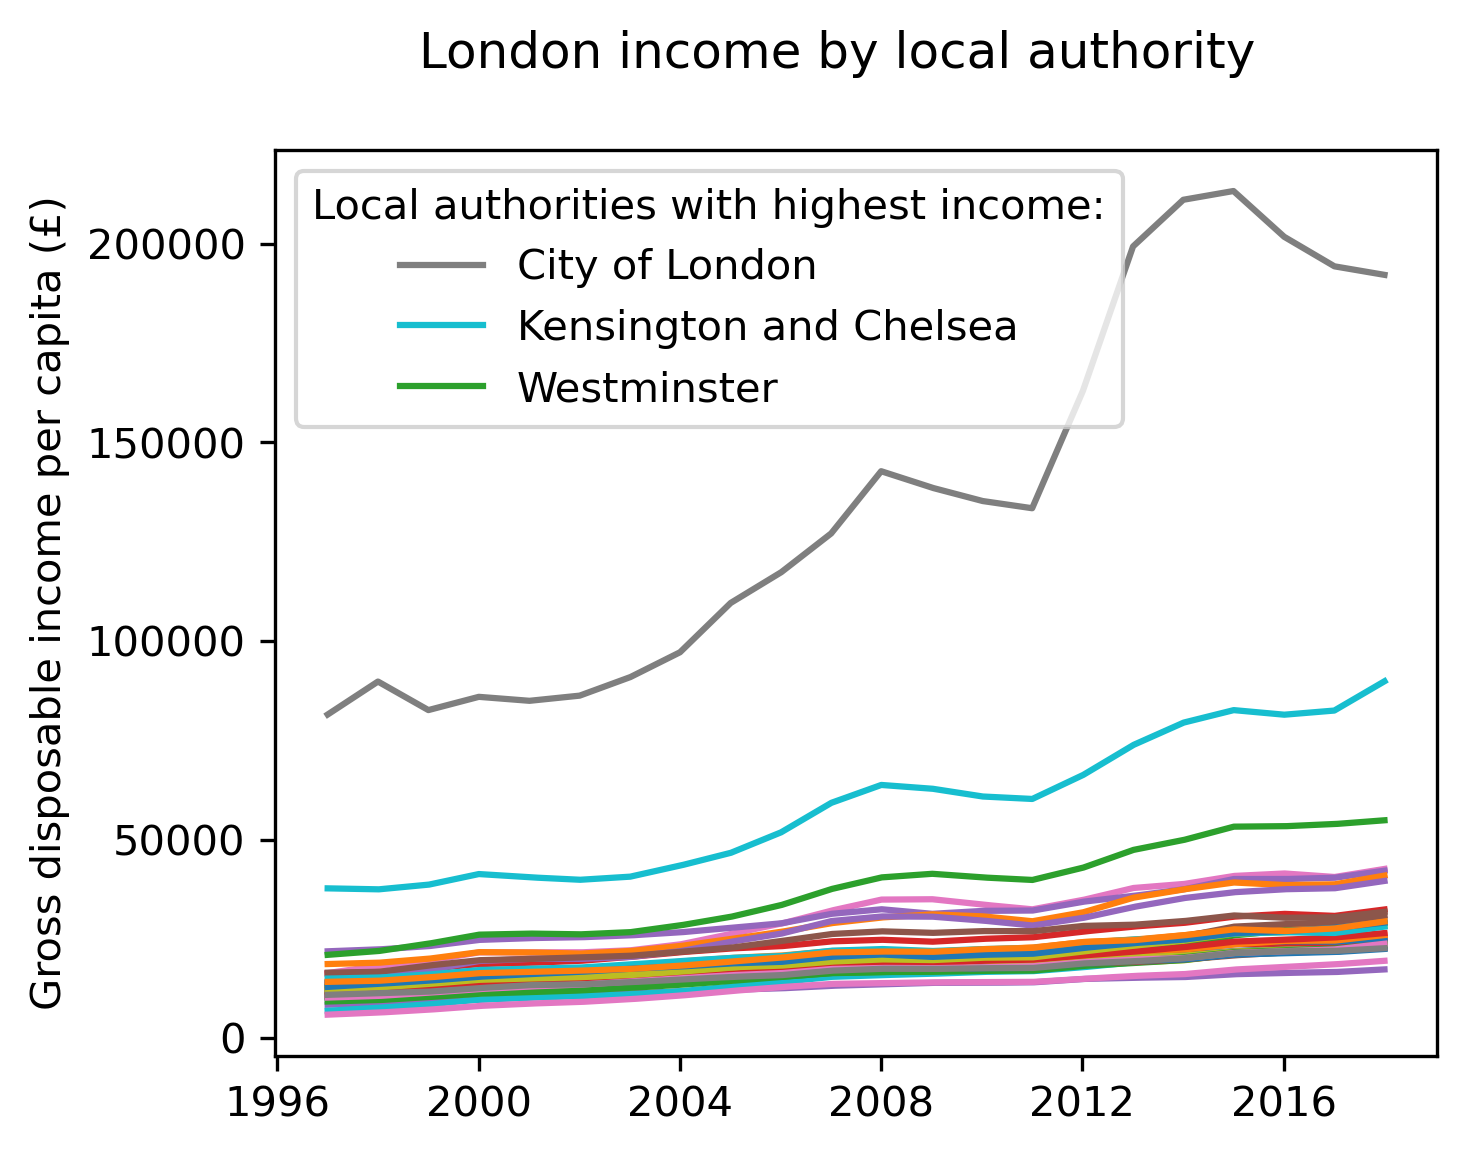

In [11]:
fig = plt.figure(figsize=(5,4), dpi=300)

for LAD_code in linear_df.columns.to_list():
    if LAD_code in rich_df.index.to_list():
        plt.plot(linear_df[LAD_code], label=LAD_codes_df.loc[LAD_code].values[0])
    else:
        plt.plot(linear_df[LAD_code], label=None)
plt.legend(title="Local authorities with highest income:")
plt.ylabel("Gross disposable income per capita (£)")
plt.suptitle("London income by local authority")
plt.show()